In [124]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import importlib
import lumped_parameter_model
import utils 
importlib.reload(lumped_parameter_model)
importlib.reload(utils)
from lumped_parameter_model import *
from utils import *
from scipy import optimize
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [83]:
hinit = 10
A = 1.86e6 #m2
w = np.sqrt(A)
l = np.sqrt(A)
kbar = 1000. #m/d
b = 20.
hs = 372.5 #m
sy = 0.2
dt = 1. 
model = Model(w=w, l = l, kbar =kbar, b = b, hs = hs, sy = sy, dt = dt)

In [84]:
#optimize each timestep
# def optimize(objective, init_vals : tuple, *args):
#     result = optimize.minimize(objective, init_vals, args =tuple(args))
#     return result
def optimize_K_by_Q(K_0, ht, rt, dt, val_data, error_fun):
    def objective(args, ht, rt, dt, val_data, error_fun): #give recharge data and observed data (validation)
        K = args[0]
        # sy = args[1]
        h, Q = model.explicit_solve(ht, rt, dt, kbar = K)
        error = error_fun([val_data], [Q])
        print(error)
        return error
    params = (K_0)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, val_data, error_fun), bounds = [(0, None)])
    return result

def optimize_K_by_h(K_0, ht, rt, dt, val_data, error_fun):
    def objective(args, ht, rt, dt, val_data, error_fun): #give recharge data and observed data (validation)
        K = args[0]
        # sy = args[1]
        h, Q = model.explicit_solve(ht, rt, dt, kbar = K)
        error = error_fun([val_data], [h])
        print(error)
        return error
    params = (K_0)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, val_data, error_fun), bounds = [(0, None)])
    return result

def optimize_K(K_0, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, error_fun):
    def objective(args, ht, rt, dt, Q_val, h_val, error_fun): #give recharge data and observed data (validation)
        K = args[0]

        Q_min = Q_range[0]
        Q_max = Q_range[1]
        h_min = h_range[0]
        h_max = h_range[1]
        h, Q = model.explicit_solve(ht, rt, dt, kbar = K)
        h_error = (error_fun([h_val], [h]) - h_min)/(h_max-h_min)
        Q_error = (error_fun([Q_val], [Q]) - Q_min)/(Q_max- Q_min)
        total_error = np.sqrt(h_error**2 + Q_error**2 + 2*corr_coeff*h_error*Q_error)
        print(h_error, Q_error)
        print(total_error)
        return total_error
    params = (K_0)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, Q_val, h_val, error_fun), bounds = [(0, None)])
    return result

def optimize_K_S(K_0, S_0, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, error_fun):
    def objective(args, ht, rt, dt, Q_val, h_val, error_fun): #give recharge data and observed data (validation)
        K = args[0]
        S = args[1]
        Q_min = Q_range[0]
        Q_max = Q_range[1]
        h_min = h_range[0]
        h_max = h_range[1]
        h, Q = model.explicit_solve(ht, rt, dt, kbar = K, sy = S)
        h_error = (error_fun([h_val], [h]) - h_min)/(h_max-h_min)
        Q_error = (error_fun([Q_val], [Q]) - Q_min)/(Q_max- Q_min)
        total_error = np.sqrt(h_error**2 + Q_error**2 + 2*corr_coeff*h_error*Q_error)
        print(h_error, Q_error)
        print(total_error)
        return total_error
    params = (K_0, S_0)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, Q_val, h_val, error_fun), bounds = [(0, None), (0,1)])
    return result

def optimize_S(S_0, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, error_fun):
    def objective(args, ht, rt, dt, Q_val, h_val, error_fun): #give recharge data and observed data (validation)
        sy = args[0]

        Q_min = Q_range[0]
        Q_max = Q_range[1]
        h_min = h_range[0]
        h_max = h_range[1]
        h, Q = model.explicit_solve(ht, rt, dt, sy = sy)
        h_error = (error_fun([h_val], [h]) - h_min)/(h_max-h_min)
        Q_error = (error_fun([Q_val], [Q]) - Q_min)/(Q_max- Q_min)
        total_error = np.sqrt(h_error**2 + Q_error**2 + 2*corr_coeff*h_error*Q_error)
        print(h_error, Q_error)
        print(total_error)
        return total_error
    params = (sy)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, Q_val, h_val, error_fun), bounds = [(0, 1)])
    return result

def optimize_S_by_Q(S_0, ht, rt, dt, val_data, error_fun):
    def objective(args, ht, rt, dt, val_data, error_fun): #give recharge data and observed data (validation)
        sy = args[0]
        # sy = args[1]
        h, Q = model.explicit_solve(ht, rt, dt, sy = sy)
        error = error_fun([val_data], [Q])
        print(error)
        return error
    params = (S_0)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, val_data, error_fun), bounds = [(0, None)])
    return result


In [87]:
#get data 
Q = convert_df_to_date_time(pd.read_csv('discharge_full_year_2018.csv'), 'Date').set_index('Date')
h = convert_df_to_date_time(pd.read_csv('2018_MRSW_year_FINAL.csv'), 'datetime').set_index('datetime')
r = convert_hourly_to_daily(convert_df_to_date_time(pd.read_csv('2017_2021_simulated_recharge_hourly.csv'), 'DATE'), 'DATE').set_index('DATE')
#clean data
Q = Q.dropna()
h = h.dropna()
r = r.dropna()
r = r[(r.index >= '2018-01-01') & (r.index <= '2018-12-31')] #get 2018 data only
h = h[h['gw_elev[m]'] > h['gw_elev[m]'].quantile(0.05)] #get rid of outliers

In [14]:
Q.join(h).dropna()

Q [m3/day]  gw_elev[ft]  gw_elev[m]
Date                                            
2018-01-18  1236.487147      1239.78  377.884944
2018-01-19  1234.079592      1239.75  377.875800
2018-01-20  1235.634708      1239.72  377.866656
2018-01-21  1207.103468      1239.70  377.860560
2018-01-22  1310.695385      1240.00  377.952000
...                 ...          ...         ...
2018-12-27  4801.543480      1244.05  379.186440
2018-12-28  8955.723993      1248.14  380.433072
2018-12-29  6541.954721      1249.50  380.847600
2018-12-30  5630.230552      1249.74  380.920752
2018-12-31  5106.665423      1249.69  380.905512

[328 rows x 3 columns]

In [19]:
#analysis of head and discharge
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import grangercausalitytests

Q_h = Q.join(h).dropna()
# Compute Spearman correlation
corr, p_value = spearmanr(Q_h['gw_elev[m]'], Q_h['Q [m3/day]'])
print(f"Spearman Correlation: {corr:.3f}, p-value: {p_value:.3f}")


# Perform Granger causality test (using up to 3 lags)
grangercausalitytests(Q_h[['Q [m3/day]', 'gw_elev[m]']], maxlag=7)

Spearman Correlation: 0.739, p-value: 0.000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2631  , p=0.1335  , df_denom=324, df_num=1
ssr based chi2 test:   chi2=2.2841  , p=0.1307  , df=1
likelihood ratio test: chi2=2.2762  , p=0.1314  , df=1
parameter F test:         F=2.2631  , p=0.1335  , df_denom=324, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9345  , p=0.0077  , df_denom=321, df_num=2
ssr based chi2 test:   chi2=10.0227 , p=0.0067  , df=2
likelihood ratio test: chi2=9.8717  , p=0.0072  , df=2
parameter F test:         F=4.9345  , p=0.0077  , df_denom=321, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6912  , p=0.0463  , df_denom=318, df_num=3
ssr based chi2 test:   chi2=8.2513  , p=0.0411  , df=3
likelihood ratio test: chi2=8.1483  , p=0.0430  , df=3
parameter F test:         F=2.6912  , p=0.0463  , df_denom=318, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

{1: ({'ssr_ftest': (2.263135259195575, 0.13345975096373247, 324.0, 1),
   'ssr_chi2test': (2.2840902152992375, 0.13070676609513662, 1),
   'lrtest': (2.2761500003471156, 0.1313776422757811, 1),
   'params_ftest': (2.2631352591957197, 0.13345975096371765, 324.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.934464858792857, 0.007749467316247461, 321.0, 2),
   'ssr_chi2test': (10.02265136427708, 0.006662065668138042, 2),
   'lrtest': (9.871668298226723, 0.0071844655301567615, 2),
   'params_ftest': (4.934464858792991, 0.007749467316246679, 321.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.691196436432685, 0.046316569398092804, 318.0, 3),
   'ssr_chi2test': (8.25130982868512, 0.04109361859473696, 3),
   'lrtest': (8.148304836759962, 0.04304409275132231, 3),
   'params_ftest': (2.691196436431921, 0.04631656939813877, 318.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

<Axes: xlabel='datetime', ylabel='gw_elev[m]'>

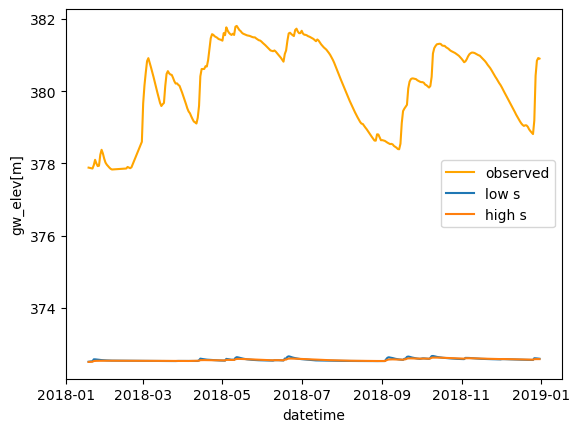

In [7]:
fig, ax = plt.subplots()
# twin = ax.twinx()
sns.lineplot(h, x = h.index, y = 'gw_elev[m]', ax = ax, label = 'observed', color = 'orange')
sns.lineplot(out_lows, x = dates, y = 'head', ax = ax, label = 'low s')
sns.lineplot(out_highs, x = dates, y = 'head', ax = ax, label = 'high s')

# twin.set_ylim(272,274)

In [5]:
#optimize K for each timestep 
Ks = pd.DataFrame(columns = ['K'])
for date in h.index[:-1]:
    ht = h.loc[date]['gw_elev[m]']
    try:
        next_date = add_to_timestamp(date, 1, 'day')
        print(next_date)
        Q_val = Q.loc[next_date]['Q [m3/day]']
        rt = r.loc[date]['RCH[m/day]']
    except:
        print(f'skipping {date}')
        continue
    dt = subtract_timestamps(next_date, date, 'day')
    result = optimize_K_by_Q(model.kbar, ht, rt, dt, Q_val, mean_squared_error)
    print(result)
    K_cal = result.x[0]
    Ks.loc[date] = [K_cal]
    previous_date = date

2018-01-19 00:00:00
45866082005.90029
45866082006.8229
45773867648.02882
45773867648.9505
45405938140.443214
45405938141.36118
43949066892.50497
43949066893.40809
38359130419.218636
38359130420.06237
19800160821.53975
19800160822.145927
23.280273743789426
23.280294529521825
3.902517332701532e-09
3.6380384425975833e-09
1.1599186697191738e-12
1.1598907535263314e-12
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 1.1599186697191738e-12
        x: [ 5.729e+00]
      nit: 4
      jac: [-2.792e-09]
     nfev: 18
     njev: 9
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
2018-01-20 00:00:00
45708885812.07076
45708885812.990234
45616985930.78883
45616985931.707375
45250311180.88165
45250311181.7965
43798408584.78062
43798408585.68064
38227540656.81929
38227540657.66015
19731948248.060154
19731948248.664257
127.97577947391247
127.97582812549369
3.6593297764011934e-08
3.577523613078463e-08
1.155925664671487e-12
1.1560117156634604e-12


In [9]:
#optimize K for each timestep 
Ks_by_h = pd.DataFrame(columns = ['K'])
for date in h.index[:-1]:
    ht = h.loc[date]['gw_elev[m]']
    try:
        next_date = add_to_timestamp(date, 1, 'day')
        print(next_date)
        h_val = h.loc[next_date]['gw_elev[m]']
        rt = r.loc[date]['RCH[m/day]']
    except:
        print(f'skipping {date}')
        continue
    dt = subtract_timestamps(next_date, date, 'day')
    result = optimize_K_by_h(model.kbar, ht, rt, dt, h_val, mean_squared_error)
    print(result)
    K_cal = result.x[0]
    Ks_by_h.loc[date] = [K_cal]


2018-01-19 00:00:00
0.3209367005116796
0.3209367005182489
0.320936269532208
0.32093626953877735
0.32093583854941915
0.32093583855598845
0.3209341146210286
0.3209341146275979
0.32092721895383197
0.3209272189603368
0.3208996370257345
0.3208996370323034
0.3207893211666215
0.3207893211731893
0.32034824737957585
0.32034824738613915
0.31858698662073426
0.31858698662727947
0.31159049381682036
0.31159049382329335
0.2843813263054965
0.2843813263116804
0.18797351552852976
0.18797351553355734
6.765459331192649e-11
6.765468869232994e-11
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 6.765459331192649e-11
        x: [ 2.163e+01]
      nit: 3
      jac: [ 9.538e-09]
     nfev: 26
     njev: 13
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
2018-01-20 00:00:00
0.3195897588128968
0.31958975881938806
0.3195893345700218
0.31958933457651306
0.31958891032742837
0.3195889103339196
0.31958721335987045
0.31958721336636164
0.31958042553469207
0.319

In [6]:
#optimize K for each timestep 
Ks_both = pd.DataFrame(columns = ['K'])
h_data, Q_data =  h['gw_elev[m]'], Q[Q.index.isin(h.index)]['Q [m3/day]']
corr_coeff = np.corrcoef(Q_data, h_data)[0,1]
Q_range= [Q_data.min(), Q_data.max()]
h_range = [h_data.min(),h_data.max()]
for date in h.index[:-1]:
    ht = h.loc[date]['gw_elev[m]']
    try:
        next_date = add_to_timestamp(date, 1, 'day')
        print(next_date)
        h_val = h.loc[next_date]['gw_elev[m]']
        Q_val = Q.loc[next_date]['Q [m3/day]']
        rt = r.loc[date]['RCH[m/day]']
    except:
        print(f'skipping {date}')
        continue
    dt = subtract_timestamps(next_date, date, 'day')
    result = optimize_K(model.kbar, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, mean_squared_error)
    print(result)
    K_cal = result.x[0]
    Ks_both.loc[date] = [K_cal]


2018-01-19 00:00:00
-94.9085868252249 2414190.767021806
2414138.833737396
-94.90858682522324 2414190.767070368
2414138.833785958
-94.9087516757957 2409337.004780602
2409285.071408623
-94.90875167579406 2409337.0048291157
2409285.071457136
-94.90940939229857 2389970.7976891566
2389918.863967901
-94.90940939229692 2389970.7977374746
2389918.864016219
-94.91201328582314 2313287.4392972477
2313235.504194965
-94.91201328582152 2313287.4393447842
2313235.5042425017
-94.92199730013245 2019057.5253116114
2019005.584945129
-94.92199730013095 2019057.525356022
2019005.5849895393
-94.95502840074606 1042194.1826810277
1042142.2257071048
-94.955028400745 1042194.1827129343
1042142.2257390114
-94.9892508113483 -0.0604897158789341
95.0223646626188
-94.98925081134833 -0.0604897151225154
95.02236466220457
-94.98925083402631 -0.05967255952171901
95.02191717016034
-94.98925083402634 -0.05967255835107881
95.02191716951927
-94.98925092461717 -0.05289097647549284
95.01820352113678
-94.9892509246172 -0.05289

In [7]:
#calibrate K and S
K_S = pd.DataFrame(columns = ['K', 'S'])
h_data, Q_data =  h['gw_elev[m]'], Q[Q.index.isin(h.index)]['Q [m3/day]']
corr_coeff = np.corrcoef(Q_data, h_data)[0,1]
Q_range= [Q_data.min(), Q_data.max()]
h_range = [h_data.min(),h_data.max()]
for date in h.index[:-1]:
    ht = h.loc[date]['gw_elev[m]']
    try:
        next_date = add_to_timestamp(date, 1, 'day')
        print(next_date)
        Q_val = Q.loc[next_date]['Q [m3/day]']
        h_val = h.loc[next_date]['gw_elev[m]']
        rt = r.loc[date]['RCH[m/day]']
    except:
        print(f'skipping {date}')
        continue
    dt = subtract_timestamps(next_date, date, 'day')
    try:
        result = optimize_K_S(model.kbar, model.sy, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, mean_squared_error)
    except ValueError:
        print(f"Skipping {date}")
        continue
    print(result)
    K_cal = result.x[0]
    S_cal = result.x[1]
    K_S.loc[date] = [K_cal, S_cal]
    previous_date = date

2018-01-19 00:00:00
-94.9085868252249 2414190.767021806
2414138.833737396
-94.90858682522324 2414190.767070368
2414138.833785958
-94.90858683342364 2414190.767021806
2414138.8337373915
-94.90913135241712 2409337.005306584
2409285.071726853
-94.9091313524155 2409337.005355097
2409285.071775366
-94.90913136054208 2409337.005306584
2409285.071726849
-94.91126633964294 2389970.800308471
2389918.8655711333
-94.91126633964133 2389970.80035679
2389918.865619452
-94.91126634748032 2389970.800308471
2389918.865571129
-94.9191614950052 2313287.450120442
2313235.511106819
-94.91916149500373 2313287.450167979
2313235.5111543564
-94.91916150180518 2313287.450120442
2313235.511106815
-94.94271743387179 2019057.566239056
2019005.614535065
-94.94271743387074 2019057.5662834672
2019005.6145794762
-94.94271743784071 2019057.566239056
2019005.6145350628
-94.97904612811575 1042194.3006451868
1042142.3305301415
-94.97904612811543 1042194.3006770936
1042142.3305620482
-94.97904612871162 1042194.3006451868
1

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.92596821229712 51.94445360598292
79.4528139658095
-94.9259668820593 51.94520068620113
79.45281285922647
-94.92596688205874 51.94520098597085
79.45281285923015
-94.92596688206628 51.94520068620113
79.45281285923231
-94.92596148738151 51.94818906073393
79.45280844157378
-94.92596148738095 51.94818936051226
79.45280844158873
-94.92596148738863 51.94818906073393
79.45280844157973
-94.92593865671344 51.960143417427425
79.45279084959778
-94.92593865671286 51.9601437172403
79.45279084965787
-94.92593865672124 51.960143417427425
79.45279084960431
-94.92582130878284 52.007974581198766
79.452716745129
-94.9258213087821 52.007974881149394
79.45271674536981
-94.9258213087946 52.007974581198766
79.45271674513883
-94.91927999014429 52.19951902823683
79.44763835964841
-94.91927999013589 52.19951932873866
79.44763836062133
-94.91927999165925 52.19951902823683
79.44763836091373
Skipping 2018-03-01 00:00:00
2018-03-03 00:00:00
-94.64095915467071 4823252.225703465
4823200.4382101605
-94.6409591546658

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.70028427160373 4566880.3848420195
4566828.564923007
-94.78945455972139 3980053.8827472716
3980002.014136611
-94.78945455971865 3980053.8828358096
3980002.014225149
-94.78945456907614 3980053.8827472716
3980002.014136606
-94.91037030901249 2036134.7852052362
2036082.8511876275
-94.9103703090115 2036134.7852685638
2036082.8512509551
-94.91037031037077 2036134.7852052362
2036082.8511876268
-94.96106795331053 -0.05593332497835009
94.99168656631475
-94.96106795331016 -0.05593332179585721
94.99168656457161
-94.96106795331654 -0.05593332497835009
94.99168656632078
-94.96106726519983 -0.04875818811835751
94.98775682739138
-94.96106726519947 -0.04875818319282261
94.98775682469397
-94.96106726520586 -0.04875818811835751
94.9877568273974
-94.9610645114228 0.010792155277535733
94.95515940403861
-94.96106451142245 0.010792167175224117
94.9551593975287
-94.96106451142887 0.010792155277535733
94.95515940404468
-94.96105347492345 0.7425902641557982
94.55674610429203
-94.96105347492308 0.7425903039

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.90170200943942 4518289.657783921
4518237.72765818
-94.97478672374965 2318553.488620851
2318501.519167241
-94.9747867237492 2318553.488692576
2318501.5192389656
-94.97478672436239 2318553.488620851
2318501.5191672407
-94.98927186902502 -0.03414811098862019
95.00796223503991
-94.98927186902502 -0.034148103258855624
95.0079622308082
-94.98927186902502 -0.03414811098862019
95.00796223503991
-94.98927186575587 0.00339891506350762
94.98741200009403
-94.98927186575587 0.0033989270243807057
94.98741199354926
-94.98927186575587 0.00339891506350762
94.98741200009403
-94.98927185235024 0.3149486792065461
94.81729634912007
-94.98927185235024 0.3149487080918865
94.81729633338111
-94.98927185235026 0.3149486792065461
94.81729634912008
-94.98927179345789 4.1429342947313765
92.7870498981241
-94.98927179345789 4.142934391314525
92.78704984833124
-94.98927179345789 4.1429342947313765
92.7870498981241
-94.98927147321636 60.763461700073044
79.98964501167379
-94.98927147321636 60.76346206744746
79.9896

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.78358957422606 6537125.785857294
6537073.920146607
-94.78358959514277 6537125.7857240075
6537073.920013309
-94.8140409362338 6325611.470558889
6325559.588201437
-94.81404093623006 6325611.470690001
6325559.588332548
-94.81404095304819 6325611.470558889
6325559.588201428
-94.89174431302423 5514337.886936907
5514285.962133841
-94.89174431302197 5514337.88705932
5514285.962256253
-94.89174432069423 5514337.886936907
5514285.962133836
-94.97551291791201 2825782.38506487
2825730.414969274
-94.97551291791152 2825782.385152499
2825730.415056903
-94.97551291857744 2825782.38506487
2825730.4149692734
-94.98902665909758 -0.04429808707272131
95.01327409273378
-94.9890266590976 -0.044298080320527795
95.01327408903676
-94.98902665909715 -0.04429808707272131
95.01327409273335
-94.98902675903912 -0.02089932246006333
95.00046461368986
-94.98902675903916 -0.020899312011248367
95.00046460797063
-94.9890267590387 -0.02089932246006333
95.00046461368943
-94.98902715863012 0.17326702764211738
94.8943251

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.97781003312677 2930129.2565809647
2930077.285188603
-94.97781003374357 2930129.2564904303
2930077.2850980684
-94.98848000901046 -0.05181977821860241
95.01684602557282
-94.98848000901053 -0.051819773130232956
95.01684602278655
-94.98848000900986 -0.05181977821860241
95.0168460255722
-94.98848014119443 -0.03890939754720387
95.00977719631506
-94.98848014119449 -0.03890938967277986
95.00977719200391
-94.98848014119383 -0.03890939754720387
95.00977719631445
-94.98848066984118 0.06822792365951731
94.95116308243264
-94.98848066984125 0.06822794267815951
94.95116307203517
-94.98848066984057 0.06822792365951731
94.95116308243203
-94.98848278300177 1.384709984824486
94.23788787305097
-94.98848278300184 1.3847100484200168
94.23788783890845
-94.98848278300115 1.384709984824486
94.23788787305035
-94.98849121278764 20.8575626508937
85.37897536960672
-94.9884912127877 20.857562892796768
85.37897528143279
-94.98849121278691 20.8575626508937
85.37897536960602
-94.9885245640128 326.05976405772
285.3

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.98861084077078 -0.06093663426592219
95.02196944877245
-94.98861084077085 -0.06093663489866525
95.02196944911906
-94.98861084076967 -0.06093663426592219
95.02196944877136
-94.98861079821492 -0.06026533680801149
95.02160176803642
-94.98861079821498 -0.06026533833655922
95.02160176887358
-94.9886107982138 -0.06026533680801149
95.0216017680353
-94.98861062801315 -0.052015410318817484
95.01708377058502
-94.9886106280132 -0.05201541543057764
95.01708377338421
-94.98861062801204 -0.052015410318817484
95.0170837705839
-94.98860994755239 0.07002008215885853
94.95031259362145
-94.98860994755246 0.07002006271422358
94.9503126042517
-94.98860994755128 0.07002008215885853
94.95031259362034
-94.98860723124334 1.982734636403527
93.91830532610527
-94.9886072312434 1.9827345596274133
93.91830536697566
-94.98860723124226 1.982734636403527
93.91830532610419
-94.98859645408983 32.4267542027266
81.87397622658821
-94.98859645408989 32.42675389662457
81.87397629968585
-94.98859645408886 32.4267542027266


c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.98799623465077 51.977976959170434
79.5047312750836
-94.98799623464721 51.97797657252666
79.50473127508097
-94.98799622924348 51.97807181461459
79.50473127053345
-94.98799622924356 51.9780722012591
79.50473127053365
-94.98799622924001 51.97807181461459
79.50473127053054
-94.98799620761662 51.97845278383884
79.50473125347446
-94.9879962076167 51.978453170484386
79.5047312534765
-94.98799620761315 51.97845278383884
79.50473125347155
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 79.50473125347446
        x: [ 4.117e+01  8.279e-01]
      nit: 7
      jac: [ 2.046e-04 -2.913e-04]
     nfev: 60
     njev: 20
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
2018-06-29 00:00:00
-94.7712609802393 6657731.451685126
6657679.592711882
-94.7712609802347 6657731.451822235
6657679.592848991
-94.77126100311077 6657731.451685126
6657679.592711869
-94.77353654481423 6644027.594071041
6643975.73385359
-94.77353654480967 6644027.594208009

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.89165902101722 3019531.5153877935
3019479.5911039948
-94.89165902101519 3019531.515448744
3019479.591164945
-94.89165903098939 3019531.5153877935
3019479.591103989
-94.89464339552893 2995200.6717032907
2995148.7457949747
-94.89464339552697 2995200.671763996
2995148.74585568
-94.89464340509325 2995200.6717032907
2995148.745794969
-94.90553046595159 2898861.534244302
2898809.60241376
-94.9055304659498 2898861.534304023
2898809.6024734806
-94.9055304740705 2898861.534244302
2898809.602413756
-94.93655056205228 2529252.7808726374
2529200.8322275667
-94.93655056205105 2529252.7809284213
2529200.8322833506
-94.93655056645441 2529252.7808726374
2529200.8322275644
-94.97927291873654 1302782.5108146837
1302730.5399690259
-94.9792729187362 1302782.5108547185
1302730.5400090606
-94.97927291928771 1302782.5108146837
1302730.5399690254
-94.9892039260749 -0.04769881292250291
95.0153134120668
-94.98920392607491 -0.047698808865750356
95.01531340984552
-94.98920392607506 -0.04769881292250291
95.015

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.84993666658673 4809302.672580183
4809250.770737805
-94.91037398082 4191493.5970736197
4191441.6622570967
-94.91037398081824 4191493.597166833
4191441.66235031
-94.91037398680403 4191493.5970736197
4191441.6622570935
-94.97685522500498 2144818.2640826004
2144766.293607549
-94.97685522500458 2144818.26414928
2144766.2936742282
-94.97685522555184 2144818.2640826004
2144766.2936075483
-94.98925560377238 -0.033999525974117345
95.00786462578029
-94.98925560377238 -0.03399951848213206
95.00786462167875
-94.98925560377232 -0.033999525974117345
95.00786462578023
-94.98925563651635 0.003754118881998633
94.98720141040172
-94.98925563651636 0.0037541304748947863
94.98720140405837
-94.9892556365163 0.003754118881998633
94.9872014104017
-94.98925576718224 0.31701674991676493
94.81615343505212
-94.98925576718226 0.31701677791329586
94.81615341979787
-94.9892557671822 0.31701674991676493
94.81615343505206
-94.98925628487981 4.166036099820653
92.77512651491087
-94.98925628487981 4.166036193431696
9

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


2018-10-16 00:00:00
-94.77158749652702 6332320.7692220565
6332268.910094428
-94.77158749652257 6332320.769350834
6332268.910223206
-94.77158751843807 6332320.7692220565
6332268.910094416
-94.77376970989842 6319449.811223414
6319397.950902699
-94.77376970989403 6319449.81135206
6319397.951031345
-94.77376973150412 6319449.811223414
6319397.950902686
-94.78222132412922 6268096.918689078
6268045.053747753
-94.78222132412496 6268096.918817198
6268045.053875873
-94.78222134456466 6268096.918689078
6268045.0537477415
-94.81205945311372 6064780.379915286
6064728.498663502
-94.81205945311002 6064780.380041313
6064728.498789529
-94.81205946958043 6064780.379915286
6064728.4986634925
-94.88862126093106 5285034.7266370645
5284982.803567731
-94.8886212609288 5285034.726754707
5284982.803685373
-94.88862126851468 5285034.7266370645
5284982.803567726
-94.97313538332394 2702380.1425953107
2702328.17385172
-94.97313538332342 2702380.1426794347
2702328.173935844
-94.97313538402295 2702380.1425953107
27

In [10]:
K_S

Empty DataFrame
Columns: [K, S]
Index: []

<Axes: xlabel='None', ylabel='K'>

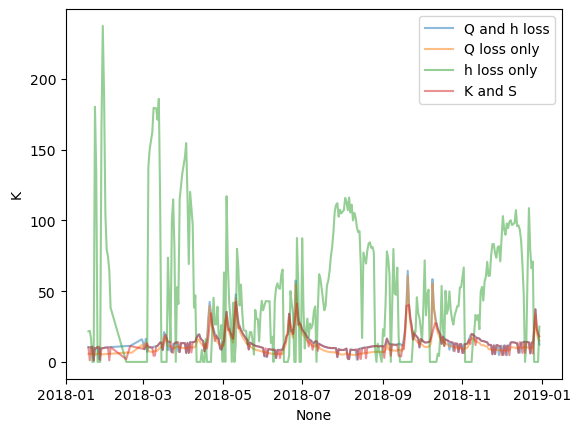

In [10]:
sns.lineplot(Ks_both, x = Ks_both.index, y = 'K', alpha = 0.5, label = 'Q and h loss')
sns.lineplot(Ks, x = Ks.index, y = 'K', alpha = 0.5, label = 'Q loss only')
sns.lineplot(Ks_by_h, x = Ks_by_h.index, y = 'K', alpha = 0.5, label = 'h loss only')
sns.lineplot(K_S, x = K_S.index, y = 'K', alpha = 0.5, label = 'K and S')

In [21]:
S = pd.DataFrame(columns = ['S'])
h_data, Q_data =  h['gw_elev[m]'], Q[Q.index.isin(h.index)]['Q [m3/day]']
corr_coeff = np.corrcoef(Q_data, h_data)[0,1]
Q_range= [Q_data.min(), Q_data.max()]
h_range = [h_data.min(),h_data.max()]
for date in h.index[:-1]:
    ht = h.loc[date]['gw_elev[m]']
    try:
        next_date = add_to_timestamp(date, 1, 'day')
        print(next_date)
        Q_val = Q.loc[next_date]['Q [m3/day]']
        h_val = h.loc[next_date]['gw_elev[m]']
        rt = r.loc[date]['RCH[m/day]']
    except:
        print(f'skipping {date}')
        continue
    dt = subtract_timestamps(next_date, date, 'day')
    try:
        result = optimize_S(model.sy, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, mean_squared_error)
    except ValueError:
        print(f"Skipping {date}")
        continue
    print(result)
    S_cal = result.x[0]
    S.loc[date] = [S_cal]
    previous_date = date

2018-01-19 00:00:00
-94.9085868252249 2414190.767021806
2414138.833737396
-94.90858683342364 2414190.767021806
2414138.8337373915
-94.98252557288936 2414190.767021806
2414138.7932796734
-94.98252557310336 2414190.767021806
2414138.7932796734
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 2414138.7932796734
        x: [ 6.657e-01]
      nit: 1
      jac: [ 0.000e+00]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
2018-01-20 00:00:00
-94.9089254535821 2405916.6439060313
2405864.710440826
-94.90892546174675 2405916.6439060313
2405864.7104408215
-94.98255499156622 2405916.6439060313
2405864.6701523033
-94.98255499177934 2405916.6439060313
2405864.670152303
-94.98353912265044 2405916.6439060313
2405864.6696138075
-94.98353912281993 2405916.6439060313
2405864.6696138075
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 2405864.6696138075
        x: [ 7.174

<Axes: xlabel='Date', ylabel='Q [m3/day]'>

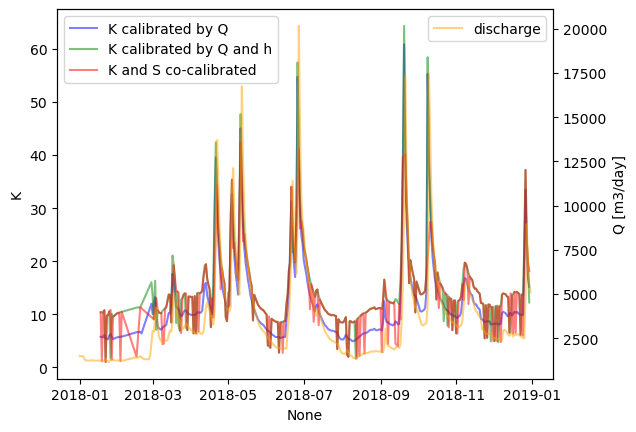

In [19]:
fig, ax = plt.subplots()
sns.lineplot(Ks, x = Ks.index, y = 'K', color = 'blue', alpha = 0.5, label = "K calibrated by Q") 
sns.lineplot(Ks_both, x = Ks_both.index, y = 'K', color = 'green', alpha = 0.5, label = "K calibrated by Q and h") 
sns.lineplot(K_S, x = K_S.index, y = 'K', color = 'red', alpha = 0.5, label = "K and S co-calibrated") 


# sns.lineplot(Ks_by_h, x = Ks_by_h.index, y = 'K')
sns.lineplot(Q, x = Q.index, y = 'Q [m3/day]', ax = ax.twinx(), color = 'orange', alpha = 0.5, label = 'discharge')

C:\Users\huan1428\AppData\Local\Temp\ipykernel_10580\3178013638.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cal_Q_results = model.explicit_solve_over_time(len(r.index), h.iloc[0]['gw_elev[m]'], r['RCH[m/day]'], kbar = Ks.mean()[0])
C:\Users\huan1428\AppData\Local\Temp\ipykernel_10580\3178013638.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cal_h_results = model.explicit_solve_over_time(len(r.index), h.iloc[0]['gw_elev[m]'], r['RCH[m/day]'], kbar = Ks_by_h.mean()[0])
C:\Users\huan1428\AppData\Local\Temp\ipykernel_10580\3178013638.py:4: FutureWarning: Series.__getitem__ treating keys as positions is depre

(0.0, 21108.8026663)

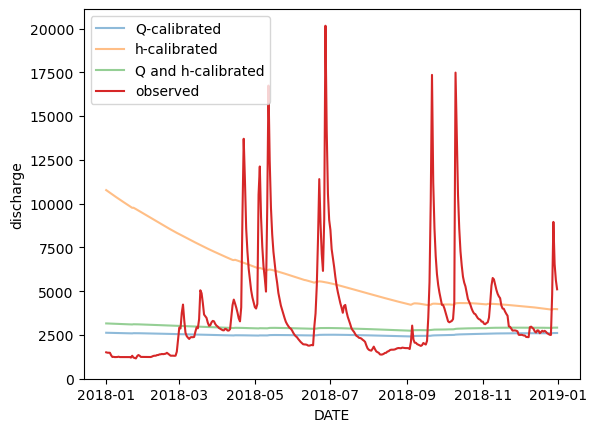

In [11]:
Ks_both.mean()
cal_Q_results = model.explicit_solve_over_time(len(r.index), h.iloc[0]['gw_elev[m]'], r['RCH[m/day]'], kbar = Ks.mean()[0])
cal_h_results = model.explicit_solve_over_time(len(r.index), h.iloc[0]['gw_elev[m]'], r['RCH[m/day]'], kbar = Ks_by_h.mean()[0])
cal_both_results = model.explicit_solve_over_time(len(r.index), h.iloc[0]['gw_elev[m]'], r['RCH[m/day]'], kbar = Ks_both.mean()[0])
sns.lineplot(cal_Q_results, x = r.index, y = 'discharge', label = 'Q-calibrated', alpha = 0.5)
sns.lineplot(cal_h_results, x = r.index, y = 'discharge', label = 'h-calibrated', alpha =0.5)
sns.lineplot(cal_both_results, x = r.index, y = 'discharge', label = 'Q and h-calibrated', alpha =0.5)

sns.lineplot(data = Q, x = Q.index, y = 'Q [m3/day]', label = 'observed')
plt.ylim(0, None)

<Axes: xlabel='DATE', ylabel='head'>

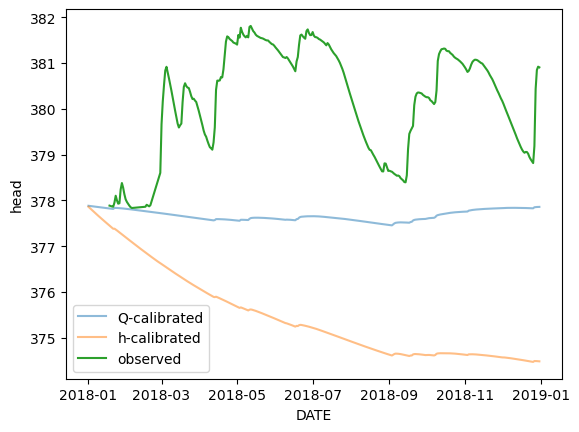

In [12]:
sns.lineplot(cal_Q_results, x = r.index, y = 'head', label = 'Q-calibrated', alpha = 0.5)
sns.lineplot(cal_h_results, x = r.index, y = 'head', label = 'h-calibrated', alpha =0.5)
sns.lineplot(data = h, x = h.index, y = 'gw_elev[m]', label = 'observed')


### Curve Fitting 
- K vs. h looks exponential
- So fit a curve using ln y = m x + b 
- Optimize params using gradient descent 
- Using curve, find elbow and define high K above elbow

<Axes: xlabel='gw_elev[m]', ylabel='K'>

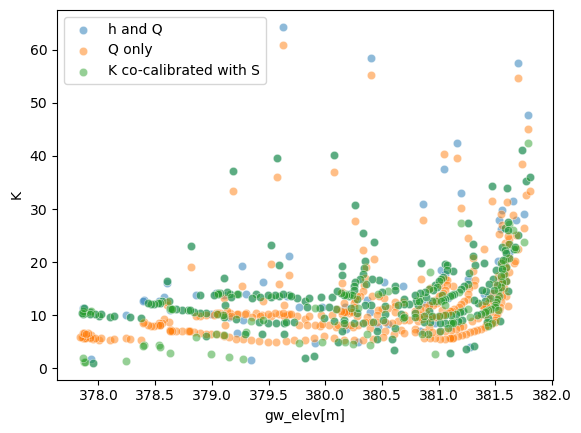

In [24]:
K_vs_h = Ks_both.join(h['gw_elev[m]'])
K_Q_vs_h = Ks.join(h['gw_elev[m]'])
K_h_vs_h = Ks_by_h.join(h['gw_elev[m]'])
K_S_vs_h = K_S.join(h['gw_elev[m]'])
S_vs_h = S.join(h['gw_elev[m]'])
sns.scatterplot(K_vs_h, y = 'K', x = 'gw_elev[m]', label = 'h and Q',alpha = 0.5)
sns.scatterplot(K_Q_vs_h, y = 'K', x = 'gw_elev[m]', label = 'Q only', alpha = 0.5)
sns.scatterplot(K_S_vs_h, y = 'K', x = 'gw_elev[m]', label = 'K co-calibrated with S', alpha = 0.5)

# plt.yscale('log')
# sns.scatterplot(K_h_vs_h, y = 'K', x = 'gw_elev[m]', label = 'h only', alpha = 0.5)

<Axes: xlabel='gw_elev[m]', ylabel='S'>

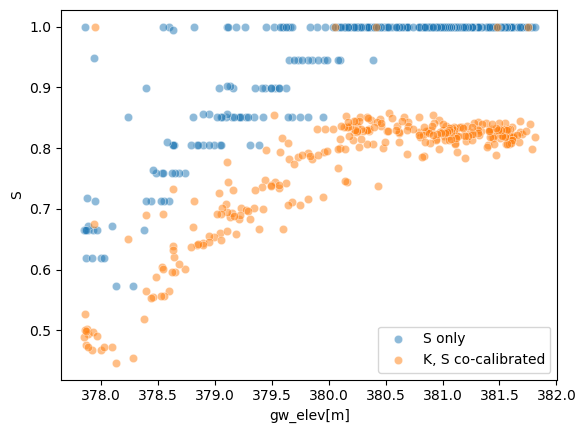

In [23]:
sns.scatterplot(S_vs_h, y = 'S', x = 'gw_elev[m]', label = 'S only', alpha = 0.5)
sns.scatterplot(K_S_vs_h, y = 'S', x = 'gw_elev[m]', label = 'K, S co-calibrated', alpha = 0.5)


<Axes: xlabel='S', ylabel='K'>

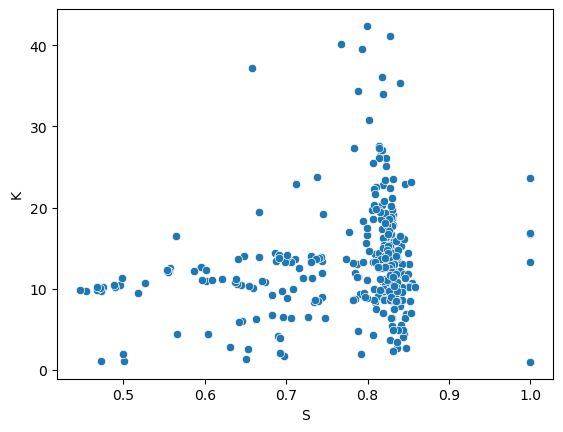

In [81]:
sns.scatterplot(K_S_vs_h, y = 'K', x = 'S')

In [ ]:
def exp_model(a, b, c, x):
    return a * np.e ** (b*x) + c

# def e_objective(args, x_vals, val_data, error_fun):
#     a = args[0]
#     b = args[1]
#     c = args[2]
#     y_test = exp_model(a,b,c,x_vals)
#     error = error_fun(val_data, y_test)
#     print(error)
#     return error
def gradient_descent(X, Y, alpha, n_iter):
    X
    a, b, c = 1,1,1
    loss_history = []
    for iteration in range(n_iter):
        y_pred = exp_model(a,b,c, X)
        grad_a = 
    


1038.8486747813736
1038.8487163987554
1038.8644991122842
1038.8486757102935
256.2226669626936
256.2226669626936
256.2226669626936
256.2226665554749
256.22264497134813
256.22264497134813
256.22264497134813
256.2226453785668
69.51798483747675
69.51798483747675
69.51798483747675
69.51798483743602
69.51798297070495
69.51798297070495
69.51798297070495
69.51798297070495


## Variable K Model

In [233]:
importlib.reload(lumped_parameter_model)
from lumped_parameter_model import *

A = 1.86e6 #m2
w = np.sqrt(A)
l = np.sqrt(A)
hk = 373
Ks = {100 : [0, hk], 1000 : [hk, 400]} #m/d
kbar = 100 #m/d
b = 50
hs = 372.5 #m
hinit = hs
sy = 0.05
dt = 1. 
varKmodel = VariableKModel(w=w, l = l, Ks = Ks, b = b, hs = hs, sy = sy, dt = dt)
model = Model(w =w, kbar = kbar, l = l, hs=hs, b=b, sy=sy, dt= dt)

timestep    discharge      head
0         0.0     0.000000  0.013478
1         1.0  1004.105785  0.016986
2         2.0  1265.481108  0.017112
3         3.0  1274.844734  0.017166
4         4.0  1278.890241  0.119457
..        ...          ...       ...
323     323.0  2157.249586  0.126361
324     324.0  9413.920439  0.066658
325     325.0  4966.047613  0.050122
326     326.0  3734.125936  0.042778
327     327.0  3186.947143  0.041340

[328 rows x 3 columns]

k: 100
qs: 0.0, qin: 1253.4474899999998, h: 372.51347793
k: 100
qs: 134.77930000021843, qin: 1330.3863899999997, h: 372.52633392021505
k: 100
qs: 263.33920215051876, qin: 1277.1699299999998, h: 372.53723532589083
k: 100
qs: 372.3532589083334, qin: 1279.8948299999997, h: 372.54699383740797
k: 100
qs: 469.93837407967476, qin: 10791.91809, h: 372.6579828666114
k: 100
qs: 1579.8286661140535, qin: 2980.2993899999997, h: 372.67304169159945
k: 100
qs: 1730.4169159945104, qin: 2092.33632, h: 372.6769332980941
k: 100
qs: 1769.3329809412717, qin: 1906.6804199999997, h: 372.67841015227754
k: 100
qs: 1784.1015227753587, qin: 1847.8709399999996, h: 372.6790958449359
k: 100
qs: 1790.9584493588682, qin: 1656.6052799999998, h: 372.67765118720087
k: 100
qs: 1776.5118720086546, qin: 1648.3664099999999, h: 372.6762732790072
k: 100
qs: 1762.73279007205, qin: 1591.0719, h: 372.6744274629849
k: 100
qs: 1744.2746298490872, qin: 1578.28533, h: 372.67264263180374
k: 100
qs: 1726.426318037397, qin: 1565.2327799

<Axes: xlabel='DATE', ylabel='discharge'>

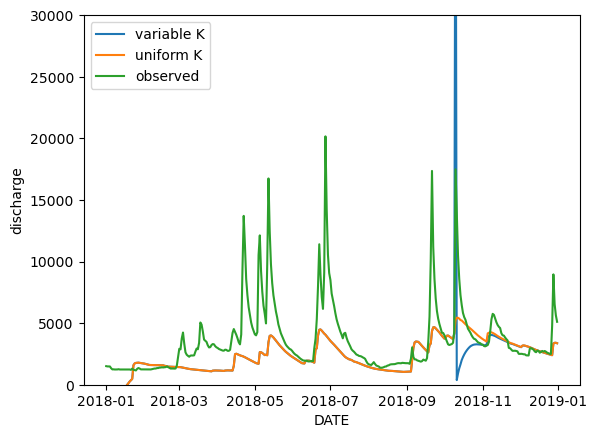

In [234]:
out_vark = varKmodel.explicit_solve_over_time(len(h), h0 =varKmodel.hs, r = r[r.index.isin(h.index)]['RCH[m/day]'], verbose = True)
out = model.explicit_solve_over_time(len(h), h0 =model.hs, r = r[r.index.isin(h.index)]['RCH[m/day]'],sy = sy)

dates = r[r.index.isin(h.index)]['RCH[m/day]'].index
sns.lineplot(out_vark, x = dates, y = 'discharge', label = 'variable K')
sns.lineplot(out, x = dates, y = 'discharge', label = 'uniform K')
plt.ylim(0, 30000)
sns.lineplot(Q, x = Q.index, y ='Q [m3/day]', label = 'observed')

<Axes: xlabel='DATE', ylabel='Head'>

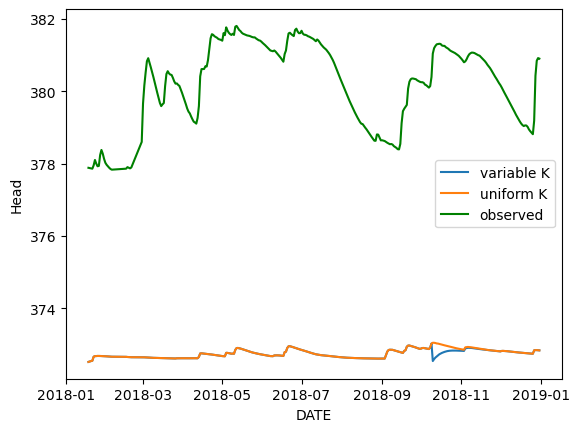

In [235]:
fig, ax = plt.subplots()
# twin =ax.twinx()
sns.lineplot(out_vark, x = dates, y = 'head', label = 'variable K', ax = ax)
sns.lineplot(out, x = dates, y = 'head', label = 'uniform K', ax = ax)
ax.set_ylabel("Head")
sns.lineplot(h, x = h.index, y ='gw_elev[m]', label = 'observed', ax = ax, color = 'green')

<Axes: xlabel='DATE', ylabel='head'>

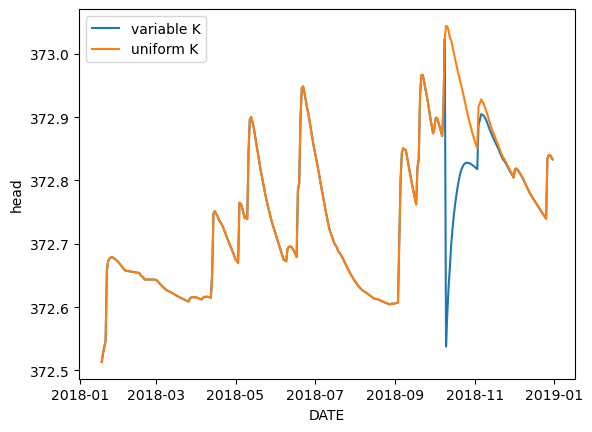

In [236]:
fig, ax = plt.subplots()
sns.lineplot(out_vark, x = dates, y = 'head', label = 'variable K',)
sns.lineplot(out, x = dates, y = 'head', label = 'uniform K',)

<Axes: xlabel='DATE', ylabel='head'>

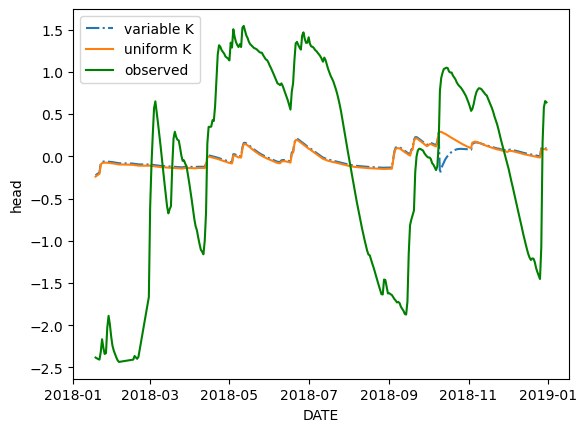

In [237]:
sns.lineplot(out_vark, x = dates, y = out_vark['head'] - out_vark['head'].mean(), label = 'variable K', linestyle= '-.')
sns.lineplot(out, x = dates, y = out['head'] - out['head'].mean(), label = 'uniform K',)
sns.lineplot(h, x = h.index, y =h['gw_elev[m]'] - h['gw_elev[m]'].mean(), label = 'observed', color = 'green')

In [239]:
Ks = varKmodel.optimize_K_2layer_by_timestep(200, 100, 372, Q[Q.index.isin(h.index)]['Q [m3/day]'], h['gw_elev[m]'],r['RCH[m/day]'], verbose = True)

2018-01-19 00:00:00
k: 1000
qs: 538494.4000000019, qin: 1253.4474899999998, h: 372.1081595644086
-309.55298801382287 100264011.42175956
100264011.42223743
k: 1000
qs: 538494.4000000019, qin: 1253.4474899999998, h: 372.1081595644086
-309.55298801382287 100264011.42175956
100264011.42223743
k: 1000
qs: 538494.4000000019, qin: 1253.4474899999998, h: 372.1081595644086
-309.55298801382287 100264011.42175956
100264011.42223743
k: 1000
qs: 538494.4000000019, qin: 1253.4474899999998, h: 372.1081595644086
-309.55298801382287 100264011.42175956
100264011.42223743
Q metrics: std = 2878.885892112182, mean = 3916.230590420731
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 100264011.42223743
        x: [ 2.000e+02  1.000e+02  3.720e+02]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00]
     nfev: 4
     njev: 1
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
2018-01-20

In [241]:
Ks

K1     K2     hk
2018-01-18  200.0  100.0  372.0
2018-01-19  200.0  100.0  372.0
2018-01-20  200.0  100.0  372.0
2018-01-21  200.0  100.0  372.0
2018-01-22  200.0  100.0  372.0
...           ...    ...    ...
2018-12-26  200.0  100.0  372.0
2018-12-27  200.0  100.0  372.0
2018-12-28  200.0  100.0  372.0
2018-12-29  200.0  100.0  372.0
2018-12-30  200.0  100.0  372.0

[322 rows x 3 columns]